In [17]:
import os
from functools import partial
from time import strftime

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

plt.style.use("dark_background")
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
# Get project files
#!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
#!unzip cats_and_dogs.zip

PATH = "cats_and_dogs"

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")
test_dir = os.path.join(PATH, "test")

# Get number of files in each directory. The train and validation directories
# each have the subdirectories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 32
epochs = 150
IMG_HEIGHT = 128
IMG_WIDTH = IMG_HEIGHT

In [19]:
# 3
CLASS_LABELS = ("cat", "dog")


def parse_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    filename = tf.strings.split(image_path, "/")[-1]
    class_name = tf.strings.split(filename, ".")[0]
    label_index = tf.cast(tf.equal(class_name, CLASS_LABELS[1]), tf.int32)
    return image, label_index


preprocessing_layer = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(scale=1.0 / 255),
        tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH, pad_to_aspect_ratio=True),
    ]
)


def get_dataset(directory, cache=False, shuffle=False, batch=True):
    ds = (
        tf.data.Dataset.list_files([directory + _ for _ in ["/*/*.jpg", "/*.jpg"]])
        .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            lambda image, label_index: (preprocessing_layer(image), label_index),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    )

    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(2_000)
    if batch:
        ds = ds.batch(batch_size)
    return ds.prefetch(tf.data.AUTOTUNE)


train_ds = get_dataset(train_dir, cache=True, shuffle=True)
validation_ds = get_dataset(validation_dir, cache=True)
test_ds = get_dataset(test_dir)

In [20]:
# 4
def plot_images(images_arr, probabilities=False):
    fig, axes = plt.subplots(
        ncols=len(images_arr), nrows=1, figsize=(len(images_arr) * 3, 5)
    )
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis("off")
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img, vmin=0, vmax=1)
            ax.axis("off")
            if probability > 0.5:
                ax.set_title("%.2f" % (probability * 100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1 - probability) * 100) + "% cat")
    plt.show()

In [21]:
# 5
data_augmentation_layer = tf.keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.1, value_range=(0, 1)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomRotation(0.05),
    ]
)

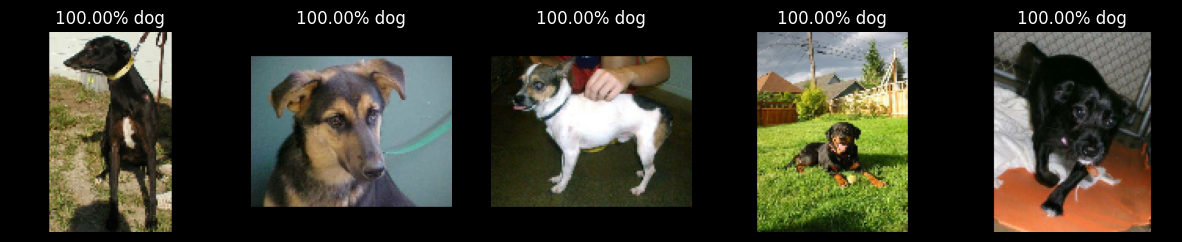

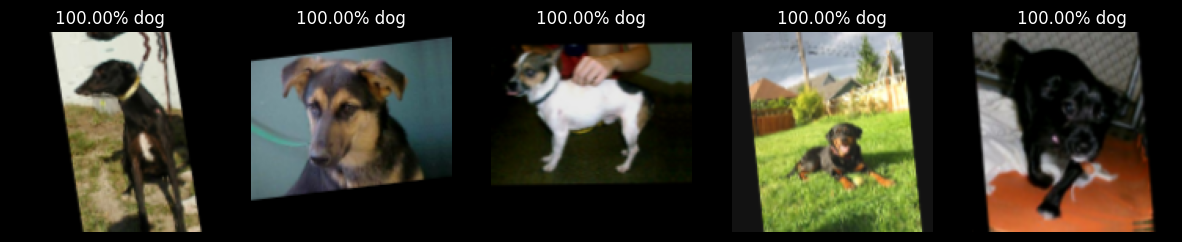

In [22]:
# 6
sample_training_images, sample_training_labels = next(iter(train_ds))
sample_training_images, sample_training_labels = (
    sample_training_images[:5],
    sample_training_labels[:5].numpy(),
)
plot_images(sample_training_images, sample_training_labels)

augmented_images = data_augmentation_layer(sample_training_images, training=True)

plot_images(augmented_images, sample_training_labels)

In [23]:
# 7

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)

DefaultDense = partial(
    tf.keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
)


def make_model(learning_rate=0.01):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
            # data_augmentation_layer,
            DefaultConv2D(filters=64, kernel_size=7),
            tf.keras.layers.MaxPool2D(),
            DefaultConv2D(filters=128),
            DefaultConv2D(filters=128),
            tf.keras.layers.MaxPool2D(),
            DefaultConv2D(filters=256),
            DefaultConv2D(filters=256),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.GlobalAveragePooling2D(),
            DefaultDense(units=128),
            # tf.keras.layers.Dropout(0.5),
            DefaultDense(units=64),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(units=1, activation="sigmoid"),
        ]
    )

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate, momentum=0.9, nesterov=True
        ),
        metrics=["accuracy"],
    )

    return model


model = make_model()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,157,377 (4.42 MB)

 Trainable params: 1,157,377 (4.42 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, starting_lr, end_lr, n_iter, log_dir=None):
        self.factor = (end_lr / starting_lr) ** (1 / n_iter)
        self.starting_lr = starting_lr
        self.end_lr = end_lr
        self.learning_rates, self.losses = [], []
        self.file_writer = (
            tf.summary.create_file_writer(log_dir + "/exp_learning_rate")
            if log_dir
            else None
        )

    def on_train_begin(self, logs=None):
        self.model.optimizer.learning_rate = self.starting_lr

    def on_train_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()

        if logs:
            self.learning_rates.append(lr)
            self.losses.append(logs["loss"])

        if logs and self.file_writer:
            with self.file_writer.as_default():
                tf.summary.scalar(
                    "Learning Rate",
                    lr,
                    step=batch,
                )
                tf.summary.scalar(
                    "Loss",
                    logs["loss"],
                    step=batch,
                )

        new_lr = lr * self.factor
        if new_lr > self.end_lr:
            self.model.stop_training = True
            print("\nReached end learning rate, stopping training")
        else:
            self.model.optimizer.learning_rate = new_lr

In [25]:
exponential_learning_rate_cb = ExponentialLearningRate(1e-9, 1, 1000)

history = model.fit(
    train_ds,
    epochs=100,
    callbacks=[exponential_learning_rate_cb],
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5147 - loss: 0.7122
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5017 - loss: 0.7169
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4984 - loss: 0.7183
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4998 - loss: 0.7164
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4714 - loss: 0.7264
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5058 - loss: 0.7144
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4910 - loss: 0.7145
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4814 - loss: 0.7096
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4453 - loss: 0.6966
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5180 - loss: 0.6923
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5054 - loss: 0.6908
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step

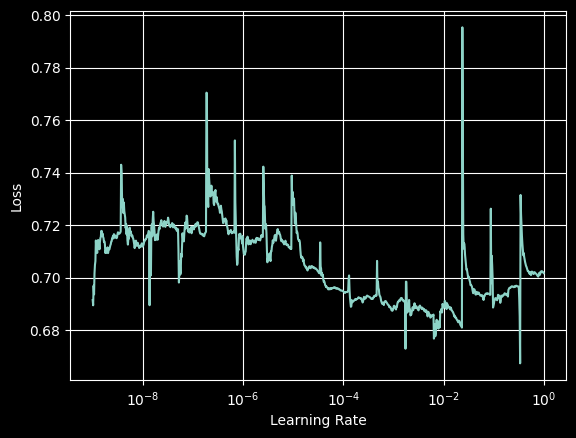

In [26]:
fig, ax = plt.subplots()

ax.plot(
    exponential_learning_rate_cb.learning_rates,
    exponential_learning_rate_cb.losses,
)
ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Loss")
ax.grid(True)

plt.show()

In [27]:
# 8
model = make_model(learning_rate=1e-4)

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[
        tf.keras.callbacks.TensorBoard(
            f"logs/cat_dog/{strftime('run_%H_%M_%S')}",
        ),
    ],
)

Epoch 1/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5192 - loss: 0.7170 - val_accuracy: 0.5010 - val_loss: 0.6932
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5167 - loss: 0.6928 - val_accuracy: 0.5320 - val_loss: 0.6908
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5127 - loss: 0.6921 - val_accuracy: 0.5330 - val_loss: 0.6891
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5201 - loss: 0.6906 - val_accuracy: 0.5560 - val_loss: 0.6865
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5685 - loss: 0.6887 - val_accuracy: 0.5290 - val_loss: 0.6850
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5451 - loss: 0.6866 - val_accuracy: 0.5000 - val_loss: 0.6870
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5418 - loss: 0.6869 - val_accuracy: 0.6400 - val_loss: 0.6823
Epoch 8/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6028 - loss: 0.6845 - val_accuracy: 0.

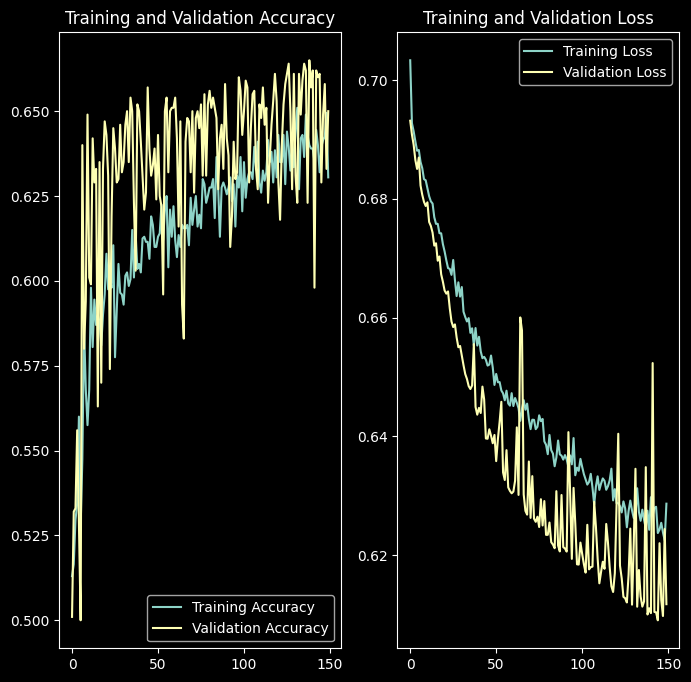

In [28]:
# 9
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [29]:
# 10
probabilities = model.predict(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  


In [30]:
# 11
answers = [
    1,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
]

correct = 0

for probability, answer in zip(probabilities, answers):
    if np.round(probability) == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(
    f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs."
)

if passed_challenge:
    print("You passed the challenge!")
else:
    print(
        "You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!"
    )

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
